# Project 1 - Market Basket Analysis for E-Commerce
### by Azubuogu Peace Udoka


## Introduction

### Background
As a data analyst at a retail company, I have access to a dataset containing customer transactions. The task is to perform market basket analysis to uncover patterns in customer purchasing behavior. By identifying which products  tend  to  be  bought  together,  the  company  can  make  informed  decisions  to  improve  sales  and  customer satisfaction.

### Questions
In the course of this analysis, the following questions will be answered:

1. What are the most frequently purchased items?

2. What are the least frequently purchased items?

3. Which items are commonly bought together in a single transaction?

4. Are there items that customers are likely to buy after viewing a particular product?

5. How can products be paired to improve sales in less frequently bought items?

Let's dive right in!

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#set general style of plots
sns.set(rc = {'figure.figsize':(20,8)}, style="white", font_scale=1.2)

#import transaction encoder function and apriori from mlxtend. Ensure mlxtend is installed before running
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

### Understanding the Dataset

In [2]:
data = pd.read_csv("Market Basket Analysis - Groceries_dataset.csv")
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns')

There are 38765 rows and 3 columns


In [3]:
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Dataset Description
The dataset contains information about customer transactions. There are 38765 rows of customer transactions and 3 columns:
- Member_number: This is the unique identifier for  customers. Note, a customer may perform multiple transactions. 
- Date: This is the date at which the transaction was done.
- itemDescription: This is the item bought.


## Data Wrangling
To improve efficiency, the column names will be replaced with more intuitive names.

- Member_number will be changed to cust_id.

- itemDescription will be changed to <b>item</b>.


In [4]:
data.rename(columns={"Member_number":"cust_id", "itemDescription":"item"},inplace= True)

In [5]:
data.head()

,cust_id,Date,item
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [6]:
data.item.nunique()

167

There are 167 different items being bought.

To know the items bought together, group the data by date and then by cust_id. This will display the items bought by a customer on the same day. 

The number of each item bought is not of use to us. We only need to know the items bought together. To show this information in a more concise manner, rearrange the dataframe such that items bought together by each customer appears on the same row, separated by commas


In [7]:
new_data = data.groupby(["Date","cust_id"], as_index=False)['item'].agg(','.join)
new_data

,Date,cust_id,item
0,01-01-2014,1249,"citrus fruit,coffee"
1,01-01-2014,1381,"curd,soda"
2,01-01-2014,1440,"other vegetables,yogurt"
3,01-01-2014,1659,"specialty chocolate,frozen vegetables"
4,01-01-2014,1789,"hamburger meat,candles"
...,...,...,...
14958,31-10-2015,4322,"brown bread,chocolate"
14959,31-10-2015,4675,"pip fruit,pastry"
14960,31-10-2015,4773,"salty snack,other vegetables,yogurt,other vege..."
14961,31-10-2015,4882,"tropical fruit,pickled vegetables"


In [8]:
# convert items column to a list of lists to enable onehot encoding
transactions = new_data["item"].apply(lambda x: x.split(','))
transactions = list(transactions)

In [9]:
# instantiate the transaction encoder and one-hot encode the data
encoder = TransactionEncoder().fit(transactions)
onehot = encoder.transform(transactions)
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 1. What are the most frequently purchased items? 
The most frequently bougth items are items with high support.

### Calculating Support

In [10]:
support = onehot.mean()
support.sort_values(ascending = False)

whole milk               0.157923
other vegetables         0.122101
rolls/buns               0.110005
soda                     0.097106
yogurt                   0.085879
                           ...   
frozen chicken           0.000334
bags                     0.000267
baby cosmetics           0.000200
kitchen utensil          0.000067
preservation products    0.000067
Length: 167, dtype: float64

The results above show that the whole milk is the most frequently bought item while preservation products are the least bought. 

Visualizing this information to show most frequently bought items.

In [11]:
df = pd.DataFrame(support, columns = {"support"})
df = df.rename_axis("item").reset_index()
df

,item,support
0,Instant food products,0.004010
1,UHT-milk,0.021386
2,abrasive cleaner,0.001470
3,artif. sweetener,0.001938
4,baby cosmetics,0.000200
...,...,...
162,white bread,0.023993
163,white wine,0.011696
164,whole milk,0.157923
165,yogurt,0.085879


In [28]:
topfreq = df.sort_values(by="support", ascending= False).head(10)
topfreq

,item,support
164,whole milk,0.157923
102,other vegetables,0.122101
122,rolls/buns,0.110005
138,soda,0.097106
165,yogurt,0.085879
123,root vegetables,0.069572
156,tropical fruit,0.067767
12,bottled water,0.060683
130,sausage,0.060349
30,citrus fruit,0.053131


C:\ProgramData\Anaconda3\New folder (3)\lib\site-packages\seaborn\categorical.py:339: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\ProgramData\Anaconda3\New folder (3)\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


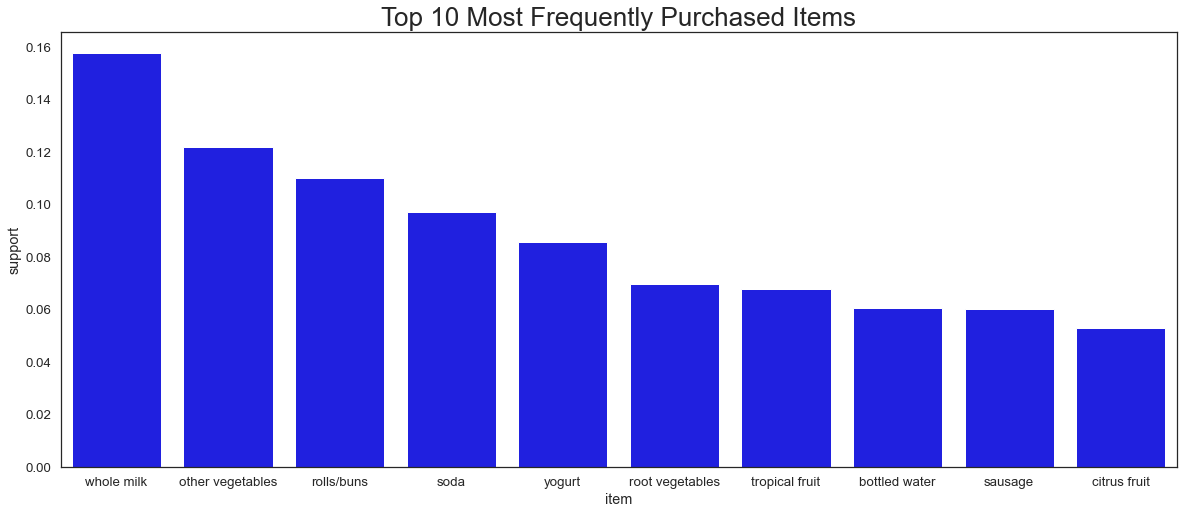

In [33]:
sns.barplot(data = topfreq, x = "item", y="support", color = "blue");
plt.title('Top 10 Most Frequently Purchased Items', fontsize=26);

## 2. What are the least frequently purchased items?
These are items with the lowest support.

In [34]:
leastfreq = df.sort_values(by="support", ascending= False).tail(10)
leastfreq

,item,support
161,whisky,0.000535
126,salad dressing,0.000401
86,make up remover,0.000334
155,toilet cleaner,0.000334
57,frozen chicken,0.000334
124,rubbing alcohol,0.000334
5,bags,0.000267
4,baby cosmetics,0.000200
79,kitchen utensil,0.000067
114,preservation products,0.000067


C:\ProgramData\Anaconda3\New folder (3)\lib\site-packages\seaborn\categorical.py:339: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\ProgramData\Anaconda3\New folder (3)\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


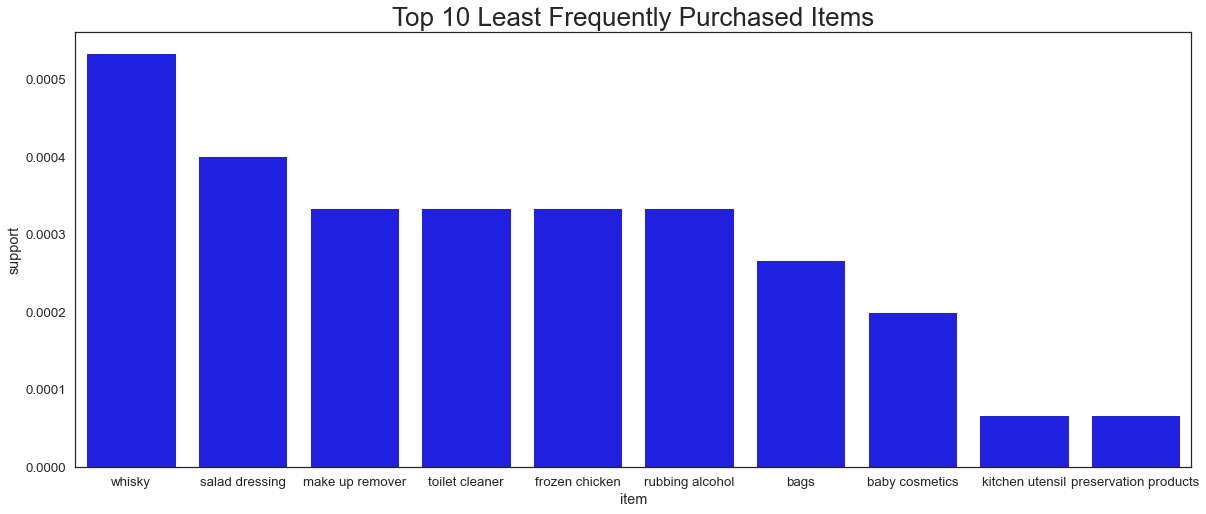

In [35]:
sns.barplot(data = leastfreq, x = "item", y="support", color = "blue");
plt.title('Top 10 Least Frequently Purchased Items', fontsize=26);

## 3. Which items are commonly bought together in a single transaction?

These are items with lift greater than 1. To compute this metric, some aggregations and pruning need to be done.

<b> Note</b>: Because there are too many items being sold, there will be a very large possible combination of sets of items. To perform proper analysis, use the Apriori principle to reduce the number of sets of items which works by pruning all subsets of infrequent sets and retaining all frequent sets and subsets.

In [14]:
support.describe()

count    167.000000
mean       0.015210
std        0.023381
min        0.000067
25%        0.002038
50%        0.005681
75%        0.017644
max        0.157923
dtype: float64

From the summary statistics of the support of the items, it is seen that the median support value is about 0.005. This will be used as the support threshold.  That is, all items with support values above 0.05 will be considered as frequent.

In [20]:
# applying Apriori algorithm
freq_items = apriori(onehot, min_support = 0.005, use_colnames = True)
len(freq_items)

126

In [25]:
freq_items

,support,itemsets
0,0.021386,(UHT-milk)
1,0.008087,(baking powder)
2,0.033950,(beef)
3,0.021787,(berries)
4,0.016574,(beverages)
...,...,...
121,0.011629,"(whole milk, soda)"
122,0.005814,"(soda, yogurt)"
123,0.008220,"(whole milk, tropical fruit)"
124,0.005213,"(yogurt, tropical fruit)"


In [40]:
# identify rules with a minimum support threshold of 0.005
rules = association_rules(freq_items, metric = "support", min_threshold = 0.005)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(bottled beer),0.157923,0.045312,0.007151,0.045281,0.999330,-0.000005,0.999968,-0.000795
1,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874,-0.000702
2,(bottled water),(other vegetables),0.060683,0.122101,0.005480,0.090308,0.739619,-0.001929,0.965051,-0.272617
3,(other vegetables),(bottled water),0.122101,0.060683,0.005480,0.044882,0.739619,-0.001929,0.983457,-0.286230
4,(whole milk),(bottled water),0.157923,0.060683,0.007151,0.045281,0.746196,-0.002432,0.983868,-0.287708
...,...,...,...,...,...,...,...,...,...,...
69,(tropical fruit),(whole milk),0.067767,0.157923,0.008220,0.121302,0.768108,-0.002482,0.958323,-0.244626
70,(yogurt),(tropical fruit),0.085879,0.067767,0.005213,0.060700,0.895720,-0.000607,0.992477,-0.112970
71,(tropical fruit),(yogurt),0.067767,0.085879,0.005213,0.076923,0.895720,-0.000607,0.990298,-0.111019
72,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638,-0.203508


In [38]:
items_bought_together = rules[rules['lift']>1]
items_bought_together[['antecedents','consequents']]

,antecedents,consequents
12,(frankfurter),(other vegetables)
13,(other vegetables),(frankfurter)
54,(soda),(sausage)
55,(sausage),(soda)
58,(yogurt),(sausage)
59,(sausage),(yogurt)


These items are commonly bought together.

## 4. Are there items that customers are likely to buy after viewing a particular product?

These are items with high confidence.

In [36]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.100394,0.100394,0.007229,0.082724,0.830099,-0.001661,0.980537,-0.185650
std,0.040823,0.040823,0.002439,0.034744,0.103803,0.001168,0.014098,0.110415
min,0.037091,0.037091,0.005012,0.031739,0.621522,-0.004446,0.944615,-0.409559
25%,0.067767,0.067767,0.005480,0.052101,0.768108,-0.002432,0.971885,-0.259307
50%,0.097106,0.097106,0.006282,0.078144,0.815816,-0.001476,0.979938,-0.203230
75%,0.122101,0.122101,0.008087,0.106360,0.855703,-0.000845,0.989940,-0.149847
max,0.157923,0.157923,0.014837,0.157817,1.116150,0.000565,1.016420,0.118536


From the summary statistics above, the median confidence is 0.07. This will be used as minimum confidence threshold to prune the dataset to know which items are likely to be bought after viewing a particular item

In [48]:
items_with_high_confidence = rules[rules["confidence"]>0.07]
items_with_high_confidence[['antecedents','consequents']]

,antecedents,consequents
1,(bottled beer),(whole milk)
2,(bottled water),(other vegetables)
5,(bottled water),(whole milk)
7,(canned beer),(whole milk)
9,(citrus fruit),(whole milk)
11,(domestic eggs),(whole milk)
12,(frankfurter),(other vegetables)
15,(frankfurter),(whole milk)
17,(newspapers),(whole milk)
18,(rolls/buns),(other vegetables)


The items above show items which the consequents are commonly bought after viewing the antecedent.

## 5. How can products be paired to improve sales in less frequently bought items?

To improve sales in less frequently bought items (items with low support) , pair with antecedents that have high support and a high confidence.